# Final Project - Basics of deep learning

## Part Three - End-to-End CNN

### Name and ID:
Student 1: Ofir Almog 207918731
<br>
Student 2: Adir Edri 206991762

## Import Libraries

In [ ]:
%%capture
!pip install ipython-autotime
%load_ext autotime

# General Libraries
import os
import time
import copy
import json
import shutil
import zipfile
import tempfile
import glob
from collections import Counter
import io

# Data Handling and Analysis
import pandas as pd
import numpy as np
import scipy.io
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, accuracy_score
from tqdm import tqdm

# Image Processing
from PIL import Image
import torchvision.transforms as transforms
import torchvision
from torchvision.datasets import ImageFolder

# Machine Learning and Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

# Plotting and Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# External Libraries
import kagglehub
import gdown

# Google Colab Utilities
from google.colab import drive, files

time: 322 µs (started: 2025-03-17 11:27:50 +00:00)


## Dataset
Cars196 - 196 different classes of vehicles

### Download Data

This block downloads the Stanford Cars dataset and its Excel mapping file. The dataset is organized into a designated folder, and the mapping file is read and processed for consistency between the training and test data.

In [ ]:
# Download latest version
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")

100%|██████████| 1.82G/1.82G [01:24<00:00, 23.3MB/s]


time: 1min 39s (started: 2025-03-17 11:27:50 +00:00)


In [ ]:
!mkdir /content/dataset
!mv /root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/* /content/dataset

time: 205 ms (started: 2025-03-17 11:29:29 +00:00)


In [ ]:
#download exel mapping file
file_id = "1FC1UietmwhfP4ROpwZfVbzzwCX8kRP85" #stanford cars exel file id
xls_path = "/content/cars_mapping.xlsx"
gdown.download(f"https://drive.google.com/uc?id={file_id}", xls_path, quiet=False) #sharing premissions enabled
df_mapping = pd.read_excel(xls_path)
df_test_mapping = pd.read_excel(xls_path, sheet_name="test")
df_test_mapping["image"] = df_test_mapping["image"].astype(str).str.replace("'", "").str.strip() #change image section in test sheet to match train sheet

Downloading...
From: https://drive.google.com/uc?id=1FC1UietmwhfP4ROpwZfVbzzwCX8kRP85
To: /content/cars_mapping.xlsx
100%|██████████| 798k/798k [00:00<00:00, 147MB/s]


time: 6.57 s (started: 2025-03-17 11:29:29 +00:00)


### Data Preproccesing

This block of code handles the preparation and organization of image data for training and testing. It starts by defining functions to retrieve the correct class number and model name for both training and testing images based on filenames. It then displays a training image along with its correct label. The images are organized into class-specific folders for both the training and testing datasets. Lastly, it defines the transformation process to resize and normalize the images to the format required for the model training.

In [ ]:
def get_class_and_model(image_name, df_mapping, is_train=True):
    """
    Get the corrected class number and model name for a given image (train or test).

    Args:
        image_name (str): The image file name (e.g., "00163.jpg").
        df_mapping (DataFrame): DataFrame containing the correct mapping for images (train or test).
        is_train (bool): Flag to distinguish between train and test data.
                          If True, assumes the image is from the training set; otherwise, assumes it's from the test set.

    Returns:
        tuple: (correct_class, correct_model) if found, otherwise raises an error.
              Returns the class number and model name for the specified image.
    """

    # Search the dataframe for the row matching the given image name
    match = df_mapping[df_mapping["image"] == image_name]

    # If a matching row is found, extract the correct class and model
    if not match.empty:
        correct_class = match["class"].values[0]  # Extract class number
        correct_model = match["true_class_name"].values[0]  # Extract model name
        return correct_class, correct_model

    # If no match is found, raise an error based on whether the image is from train or test data
    if is_train:
        raise ValueError(f"Train Image {image_name} not found in train mapping file.")
    else:
        raise ValueError(f"Test Image {image_name} not found in test mapping file.")


time: 824 µs (started: 2025-03-17 11:29:35 +00:00)


In [ ]:
# Define dataset paths
train_dataset_path = "/content/dataset/cars_train/cars_train"
test_dataset_path = "/content/dataset/cars_test/cars_test"

# Function to organize images into class folders
def organize_images(df, dataset_path):
    for index, row in df.iterrows():
        image_name = row["image"]
        class_name = str(row["ture_class_name"])  # named ture in original file

        # Create class folder if it doesn't exist
        class_folder = os.path.join(dataset_path, class_name)
        os.makedirs(class_folder, exist_ok=True)

        # Move image to the correct class folder
        src_path = os.path.join(dataset_path, image_name)
        dst_path = os.path.join(class_folder, image_name)

        if os.path.exists(src_path):  # Check if the image exists before moving
            shutil.move(src_path, dst_path)

# Organize both train and test datasets
organize_images(df_mapping, train_dataset_path)
organize_images(df_test_mapping, test_dataset_path)

# Define transformations with normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet50, ResNet18, etc. input size
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet50
])

# Load datasets with transformations
train_dataset = ImageFolder(root=train_dataset_path, transform=transform)
test_dataset = ImageFolder(root=test_dataset_path, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Create a dictionary of dataloaders for training and validation
dataloaders = {
    'train': train_loader,
    'val': test_loader  # Using test data as validation for now
}

# Print dataset details
print(f"Train Dataset Size: {len(train_dataset)} images")
print(f"Test Dataset Size: {len(test_dataset)} images")
print(f"Number of Classes: {len(train_dataset.classes)}")

Train Dataset Size: 8144 images
Test Dataset Size: 8041 images
Number of Classes: 196
time: 1.85 s (started: 2025-03-17 11:29:35 +00:00)


### Experiment Tracker Class

This block defines the ExperimentTracker class, which is used to track multiple experiments, compare their results, and save the best-performing model based on a chosen metric. It also provides functionality for visualizing and saving metrics and training histories for each experiment.



In [ ]:
class ExperimentTracker:
    """
    Class to track and compare multiple experiments.
    """
    def __init__(self, save_dir="experiment_results"):
        """
        Initialize the experiment tracker

        Args:
            save_dir: Directory to save experiment results
        """
        self.experiments = {}
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

    def add_experiment(self, name, model, metrics, history):
        """
        Add an experiment to the tracker

        Args:
            name: Name of the experiment
            model: Trained model
            metrics: Evaluation metrics
            history: Training history
        """
        self.experiments[name] = {
            "model": model,
            "metrics": metrics,
            "history": history
        }

        # Save experiment results
        self._save_experiment(name, metrics, history)

    def _save_experiment(self, name, metrics, history):
        """
        Save experiment results to disk

        Args:
            name: Name of the experiment
            metrics: Evaluation metrics
            history: Training history
        """
        exp_dir = os.path.join(self.save_dir, name)
        os.makedirs(exp_dir, exist_ok=True)

        # Save metrics and history as JSON files
        self._save_json(os.path.join(exp_dir, "metrics.json"), metrics)
        self._save_json(os.path.join(exp_dir, "history.json"), self._convert_history(history))

    def _save_json(self, file_path, data):
        """Helper function to save JSON data"""
        with open(file_path, 'w') as f:
            json.dump(data, f, indent=4)

    def _convert_history(self, history):
        """Convert non-serializable items in history to a serializable format"""
        history_serializable = {}
        for k, v in history.items():
            if isinstance(v, list) and len(v) > 0 and (isinstance(v[0], np.ndarray) or torch.is_tensor(v[0])):
                history_serializable[k] = [float(x) for x in v]
            else:
                history_serializable[k] = v
        return history_serializable

    def compare_metrics(self, metric_names=None):
        """
        Compare metrics across experiments

        Args:
            metric_names: List of metrics to compare (None for all)

        Returns:
            df: DataFrame with comparison
        """
        if not self.experiments:
            print("No experiments to compare.")
            return None

        metric_names = metric_names or self._get_default_metric_names()

        comparison = defaultdict(dict)
        for exp_name, exp_data in self.experiments.items():
            for metric in metric_names:
                comparison[metric][exp_name] = exp_data["metrics"].get(metric, None)

        df = pd.DataFrame(comparison)
        return df

    def _get_default_metric_names(self):
        """Get the default metrics names from the first experiment"""
        first_exp = next(iter(self.experiments.values()))
        return list(first_exp["metrics"].keys())

    def plot_metric_comparison(self, metric="accuracy"):
        """
        Plot comparison of a specific metric across experiments

        Args:
            metric: Metric to compare
        """
        if not self.experiments:
            print("No experiments to compare.")
            return

        values, names = [], []
        for name, exp_data in self.experiments.items():
            if metric in exp_data["metrics"]:
                values.append(exp_data["metrics"][metric])
                names.append(name)

        if not values:
            print(f"No data found for metric: {metric}")
            return

        self._plot_comparison(names, values, metric)

    def _plot_comparison(self, names, values, metric):
        """Helper function to plot metric comparison"""
        plt.figure(figsize=(10, 6))
        bars = plt.bar(names, values)
        self._add_value_labels(bars)
        plt.title(f'Comparison of {metric.capitalize()} Across Experiments')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Experiment')
        plt.ylim(0, 1.0 if max(values) < 1.0 else max(values) * 1.1)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def _add_value_labels(self, bars):
        """Helper function to add value labels to bars in a bar chart"""
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}',
                     ha='center', va='bottom')

    def plot_history_comparison(self, metric="val_acc"):
        """
        Plot comparison of training history across experiments

        Args:
            metric: History metric to compare (val_acc, train_acc, val_loss, train_loss)
        """
        if not self.experiments:
            print("No experiments to compare.")
            return

        plt.figure(figsize=(12, 6))
        for name, exp_data in self.experiments.items():
            history = exp_data["history"]
            if metric in history and len(history[metric]) > 0:
                plt.plot(history[metric], label=name)

        plt.title(f'Comparison of {metric} Across Experiments')
        plt.ylabel(metric.replace('_', ' ').capitalize())
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def find_best_experiment(self, metric="accuracy"):
        """
        Find the best experiment based on a metric

        Args:
            metric: Metric to compare

        Returns:
            best_name: Name of the best experiment
            best_value: Value of the best metric
        """
        if not self.experiments:
            print("No experiments to compare.")
            return None, None

        best_name, best_value = max(
            ((name, exp_data["metrics"].get(metric, -float('inf')))
             for name, exp_data in self.experiments.items()),
            key=lambda x: x[1], default=(None, None)
        )

        if best_name is None:
            print(f"No data found for metric: {metric}")
            return None, None

        print(f"Best experiment based on {metric}: {best_name} with value {best_value:.4f}")
        return best_name, best_value

    def save_best_model(self, metric="accuracy", save_path=None):
        """
        Save the best model based on a metric

        Args:
            metric: Metric to compare
            save_path: Path to save model (default: best_model.pth)

        Returns:
            best_name: Name of the best experiment
        """
        best_name, _ = self.find_best_experiment(metric)
        if best_name is None:
            return None

        best_model = self.experiments[best_name]["model"]
        save_path = save_path or f"best_model_{metric}.pth"
        torch.save(best_model.state_dict(), save_path)
        print(f"Best model ({best_name}) saved to {save_path}")
        return best_name

time: 3.17 ms (started: 2025-03-17 11:29:37 +00:00)


### Generic train and validation functions

This block contains functions for training, evaluating, and visualizing the performance of machine learning models. It includes a generic train_model function for training with validation, an evaluate_model function for testing the model, and a utility to plot the training history and confusion matrix. <br>
Additionally, it supports comparing multiple experiments by compiling evaluation metrics into a dataframe. The purpose is to facilitate efficient training, evaluation, and result comparison across different models or experiments.

In [ ]:
# Set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Using device: cuda:0
time: 50.3 ms (started: 2025-03-17 11:29:37 +00:00)


In [ ]:
def initialize_device():
    """Initialize device for training (GPU if available, else CPU)."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10, device=None):
    """
    Generic function to train a model with validation at each epoch.
    """
    device = device or initialize_device()  # Initialize device if not provided
    model = model.to(device)

    # Initialize history dictionary to track metrics
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'time_per_epoch': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        epoch_start_time = time.time()

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()  # Set model to train/eval mode
            running_loss, running_corrects = 0.0, 0

            pbar = tqdm(dataloaders[phase], desc=f"{phase.capitalize()}")
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=loss.item())

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Record history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_time = time.time() - epoch_start_time
        history['time_per_epoch'].append(epoch_time)
        print(f'Epoch complete in {epoch_time:.0f}s\n')

    total_time = sum(history['time_per_epoch'])
    print(f'Training complete in {total_time // 60:.0f}m {total_time % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)

    return model, history


def evaluate_model(model, dataloader, criterion, device=None):
    """
    Evaluate a model on a test set
    """
    device = device or initialize_device()  # Initialize device if not provided
    model = model.to(device)
    model.eval()

    running_loss, all_preds, all_labels = 0.0, [], []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    total_loss = running_loss / len(dataloader.dataset)
    metrics = {
        'loss': total_loss,
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds, average='weighted'),
        'precision': precision_score(all_labels, all_preds, average='weighted'),
        'recall': recall_score(all_labels, all_preds, average='weighted')
    }

    return metrics, all_labels, all_preds


def plot_training_history(history, title="Model Training History"):
    """
    Plot training and validation accuracy/loss
    """
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def compare_experiments(metrics_list, experiment_names):
    """
    Compare metrics from multiple experiments
    """
    df = pd.DataFrame(index=experiment_names)

    for i, metrics in enumerate(metrics_list):
        for metric, value in metrics.items():
            df.loc[experiment_names[i], metric] = value

    return df

time: 2.82 ms (started: 2025-03-17 11:29:37 +00:00)


# Experiment 1: Basic CNN Architecture

This experiment implements a basic Convolutional Neural Network with four convolutional layers followed by BatchNormalization and MaxPooling, and three fully connected layers with Dropout. <br>
The model uses ReLU activations and is trained with the Adam optimizer, a learning rate of 0.0001, and a StepLR scheduler with a step size of 10 epochs. The model is trained for 10 epochs and evaluated on the validation set. <br>
This serves as the baseline model for comparison with future improvements.



Setting up Experiment 1: Basic CNN
Epoch 1/10
----------


Train: 100%|██████████| 255/255 [00:27<00:00,  9.21it/s, loss=4.92]


Train Loss: 5.2636 Acc: 0.0161


Val: 100%|██████████| 252/252 [00:19<00:00, 13.17it/s, loss=4.76]


Val Loss: 4.9969 Acc: 0.0346
Epoch complete in 47s

Epoch 2/10
----------


Train: 100%|██████████| 255/255 [00:26<00:00,  9.59it/s, loss=4.9]


Train Loss: 4.6415 Acc: 0.0868


Val: 100%|██████████| 252/252 [00:18<00:00, 13.33it/s, loss=4.28]


Val Loss: 4.8648 Acc: 0.0522
Epoch complete in 46s

Epoch 3/10
----------


Train: 100%|██████████| 255/255 [00:26<00:00,  9.67it/s, loss=3.94]


Train Loss: 3.8226 Acc: 0.3336


Val: 100%|██████████| 252/252 [00:19<00:00, 13.18it/s, loss=4.1]


Val Loss: 4.7536 Acc: 0.0682
Epoch complete in 45s

Epoch 4/10
----------


Train: 100%|██████████| 255/255 [00:26<00:00,  9.64it/s, loss=2.75]


Train Loss: 2.5927 Acc: 0.7921


Val: 100%|██████████| 252/252 [00:19<00:00, 13.24it/s, loss=4.03]


Val Loss: 4.6904 Acc: 0.0852
Epoch complete in 45s

Epoch 5/10
----------


Train: 100%|██████████| 255/255 [00:26<00:00,  9.61it/s, loss=1.45]


Train Loss: 1.3496 Acc: 0.9808


Val: 100%|██████████| 252/252 [00:18<00:00, 13.44it/s, loss=5.19]


Val Loss: 4.7072 Acc: 0.0867
Epoch complete in 45s

Epoch 6/10
----------


Train: 100%|██████████| 255/255 [00:26<00:00,  9.63it/s, loss=0.44]


Train Loss: 0.5384 Acc: 0.9972


Val: 100%|██████████| 252/252 [00:18<00:00, 13.39it/s, loss=4.98]


Val Loss: 4.6955 Acc: 0.0888
Epoch complete in 45s

Epoch 7/10
----------


Train: 100%|██████████| 255/255 [00:26<00:00,  9.63it/s, loss=0.243]


Train Loss: 0.2377 Acc: 0.9972


Val: 100%|██████████| 252/252 [00:18<00:00, 13.44it/s, loss=5]


Val Loss: 4.7031 Acc: 0.0856
Epoch complete in 45s

Epoch 8/10
----------


Train: 100%|██████████| 255/255 [00:26<00:00,  9.59it/s, loss=0.289]


Train Loss: 0.1315 Acc: 0.9979


Val: 100%|██████████| 252/252 [00:18<00:00, 13.59it/s, loss=5.12]


Val Loss: 4.6835 Acc: 0.0863
Epoch complete in 45s

Epoch 9/10
----------


Train: 100%|██████████| 255/255 [00:26<00:00,  9.62it/s, loss=0.408]


Train Loss: 0.0907 Acc: 0.9980


Val: 100%|██████████| 252/252 [00:18<00:00, 13.28it/s, loss=4.87]


Val Loss: 4.6893 Acc: 0.0876
Epoch complete in 45s

Epoch 10/10
----------


Train: 100%|██████████| 255/255 [00:26<00:00,  9.62it/s, loss=0.138]


Train Loss: 0.0686 Acc: 0.9982


Val: 100%|██████████| 252/252 [00:19<00:00, 13.04it/s, loss=5.19]


Val Loss: 4.6991 Acc: 0.0878
Epoch complete in 46s

Training complete in 7m 36s
Best val Acc: 0.0888
Evaluating the basic CNN model on the validation set


Evaluating: 100%|██████████| 252/252 [00:18<00:00, 13.44it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Validation Metrics for Basic CNN:
loss: 4.6955
accuracy: 0.0888
f1: 0.0852
precision: 0.0980
recall: 0.0888


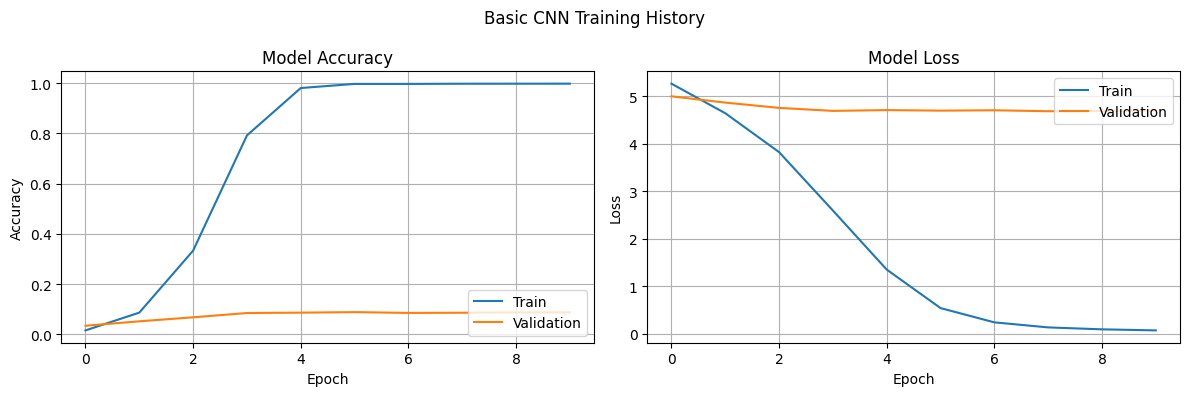

time: 7min 56s (started: 2025-03-17 11:29:37 +00:00)


In [ ]:
# Experiment 1: Basic CNN
print("Setting up Experiment 1: Basic CNN")

class BasicCNN(nn.Module):
    def __init__(self, num_classes=196):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 14 * 14, 5096)  # img size (224) / 2 / 2 / 2 / 2 (4 maxpooling) = 14
        self.bn5 = nn.BatchNorm1d(5096)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(5096, 1024)
        self.bn6 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Define the model
model_basic_cnn = BasicCNN(num_classes=len(train_dataset.classes))
model_basic_cnn = model_basic_cnn.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_basic_cnn.parameters(), lr=0.0001, weight_decay=0.001)

# Simple step scheduler for stability
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Use the dataloaders already created in the previous cell
# Train the model
num_epochs = 10
model_basic_cnn, history_basic_cnn = train_model(
    model_basic_cnn,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
    device=device
)

# Evaluate the model on the validation set
print("Evaluating the basic CNN model on the validation set")
metrics_basic_cnn, labels_basic_cnn, preds_basic_cnn = evaluate_model(
    model_basic_cnn,
    dataloaders['val'],
    criterion,
    device=device
)

# Print evaluation metrics
print("\nValidation Metrics for Basic CNN:")
for metric, value in metrics_basic_cnn.items():
    print(f"{metric}: {value:.4f}")

# Plot training history
plot_training_history(history_basic_cnn, title="Basic CNN Training History")

# Create experiment tracker and add experiment
experiment_tracker = ExperimentTracker()
experiment_tracker.add_experiment("Basic CNN", model_basic_cnn, metrics_basic_cnn, history_basic_cnn)


# Experiment 2: Enhanced CNN with Regularization and Data Augmentation


In this second experiment, we enhanced the basic CNN by adding stronger regularization techniques and data augmentation to improve generalization and reduce overfitting. <br>
Key improvements include the addition of spatial dropout (0.1) after each convolutional layer, an increase in dropout rates from 0.5 to 0.6 in fully connected layers, and the implementation of data augmentation (random flips, rotations, and color adjustments). <br>
Training was extended to 15 epochs (compared to 10 in the baseline) with a modified learning rate schedule (step_size=5, gamma=0.7) for a more gradual decay.

Setting up Experiment 2: Modified DirectCNN Implementation
Epoch 1/15
----------


Train: 100%|██████████| 255/255 [00:46<00:00,  5.45it/s, loss=5.1]


Train Loss: 5.4203 Acc: 0.0091


Val: 100%|██████████| 252/252 [00:18<00:00, 13.54it/s, loss=5.15]


Val Loss: 5.1757 Acc: 0.0196
Epoch complete in 65s

Epoch 2/15
----------


Train: 100%|██████████| 255/255 [00:47<00:00,  5.41it/s, loss=5.06]


Train Loss: 5.2419 Acc: 0.0140


Val: 100%|██████████| 252/252 [00:18<00:00, 13.28it/s, loss=5.07]


Val Loss: 5.0764 Acc: 0.0226
Epoch complete in 66s

Epoch 3/15
----------


Train: 100%|██████████| 255/255 [00:45<00:00,  5.61it/s, loss=5.17]


Train Loss: 5.1201 Acc: 0.0223


Val: 100%|██████████| 252/252 [00:18<00:00, 13.74it/s, loss=4.82]


Val Loss: 4.9863 Acc: 0.0312
Epoch complete in 64s

Epoch 4/15
----------


Train: 100%|██████████| 255/255 [00:47<00:00,  5.32it/s, loss=5.02]


Train Loss: 5.0044 Acc: 0.0303


Val: 100%|██████████| 252/252 [00:18<00:00, 13.30it/s, loss=4.78]


Val Loss: 4.9291 Acc: 0.0392
Epoch complete in 67s

Epoch 5/15
----------


Train: 100%|██████████| 255/255 [00:47<00:00,  5.40it/s, loss=5.18]


Train Loss: 4.9218 Acc: 0.0365


Val: 100%|██████████| 252/252 [00:18<00:00, 13.60it/s, loss=4.63]


Val Loss: 4.8878 Acc: 0.0425
Epoch complete in 66s

Epoch 6/15
----------


Train: 100%|██████████| 255/255 [00:46<00:00,  5.52it/s, loss=5.04]


Train Loss: 4.8221 Acc: 0.0454


Val: 100%|██████████| 252/252 [00:18<00:00, 13.35it/s, loss=4.27]


Val Loss: 4.8454 Acc: 0.0480
Epoch complete in 65s

Epoch 7/15
----------


Train: 100%|██████████| 255/255 [00:45<00:00,  5.65it/s, loss=5.01]


Train Loss: 4.7412 Acc: 0.0540


Val: 100%|██████████| 252/252 [00:18<00:00, 13.35it/s, loss=4.11]


Val Loss: 4.8114 Acc: 0.0512
Epoch complete in 64s

Epoch 8/15
----------


Train: 100%|██████████| 255/255 [00:46<00:00,  5.48it/s, loss=4.43]


Train Loss: 4.6839 Acc: 0.0614


Val: 100%|██████████| 252/252 [00:18<00:00, 13.45it/s, loss=3.69]


Val Loss: 4.7822 Acc: 0.0542
Epoch complete in 65s

Epoch 9/15
----------


Train: 100%|██████████| 255/255 [00:46<00:00,  5.53it/s, loss=4.54]


Train Loss: 4.6219 Acc: 0.0681


Val: 100%|██████████| 252/252 [00:18<00:00, 13.41it/s, loss=3.59]


Val Loss: 4.7376 Acc: 0.0616
Epoch complete in 65s

Epoch 10/15
----------


Train: 100%|██████████| 255/255 [00:46<00:00,  5.46it/s, loss=4.49]


Train Loss: 4.5647 Acc: 0.0696


Val: 100%|██████████| 252/252 [00:18<00:00, 13.46it/s, loss=3.76]


Val Loss: 4.7136 Acc: 0.0629
Epoch complete in 65s

Epoch 11/15
----------


Train: 100%|██████████| 255/255 [00:47<00:00,  5.40it/s, loss=4.68]


Train Loss: 4.4625 Acc: 0.0862


Val: 100%|██████████| 252/252 [00:19<00:00, 13.20it/s, loss=3.46]


Val Loss: 4.6713 Acc: 0.0665
Epoch complete in 66s

Epoch 12/15
----------


Train: 100%|██████████| 255/255 [00:46<00:00,  5.54it/s, loss=4.39]


Train Loss: 4.3997 Acc: 0.1027


Val: 100%|██████████| 252/252 [00:18<00:00, 13.62it/s, loss=3.46]


Val Loss: 4.6402 Acc: 0.0706
Epoch complete in 65s

Epoch 13/15
----------


Train: 100%|██████████| 255/255 [00:46<00:00,  5.53it/s, loss=4.59]


Train Loss: 4.3178 Acc: 0.1085


Val: 100%|██████████| 252/252 [00:18<00:00, 13.56it/s, loss=3.36]


Val Loss: 4.6129 Acc: 0.0731
Epoch complete in 65s

Epoch 14/15
----------


Train: 100%|██████████| 255/255 [00:46<00:00,  5.48it/s, loss=4.63]


Train Loss: 4.2578 Acc: 0.1200


Val: 100%|██████████| 252/252 [00:18<00:00, 13.30it/s, loss=3.22]


Val Loss: 4.5726 Acc: 0.0792
Epoch complete in 66s

Epoch 15/15
----------


Train: 100%|██████████| 255/255 [00:45<00:00,  5.65it/s, loss=4.29]


Train Loss: 4.1898 Acc: 0.1336


Val: 100%|██████████| 252/252 [00:18<00:00, 13.50it/s, loss=3.23]


Val Loss: 4.5436 Acc: 0.0816
Epoch complete in 64s

Training complete in 16m 18s
Best val Acc: 0.0816
Evaluating the modified model on the test set


Evaluating: 100%|██████████| 252/252 [00:18<00:00, 13.48it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Test Metrics for Modified DirectCNN:
loss: 4.5436
accuracy: 0.0816
f1: 0.0623
precision: 0.0717
recall: 0.0816


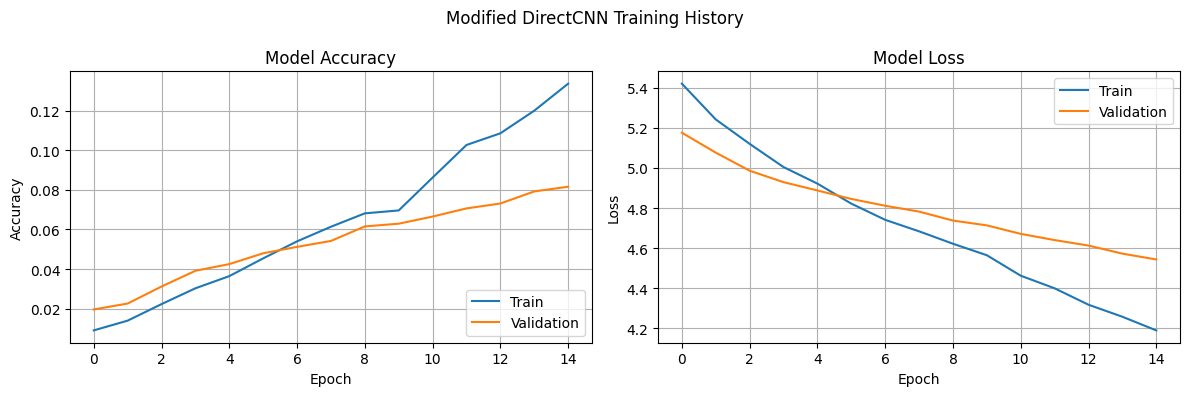

time: 16min 37s (started: 2025-03-17 11:37:34 +00:00)


In [ ]:
# Experiment 2: Modified DirectCNN with better regularization
print("Setting up Experiment 2: Modified DirectCNN Implementation")

class ModifiedDirectCNN(nn.Module):
    def __init__(self, num_classes=196):
        super(ModifiedDirectCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.spatial_dropout = nn.Dropout2d(0.1)

        self.fc1 = nn.Linear(128 * 14 * 14, 5096)
        self.bn5 = nn.BatchNorm1d(5096)
        self.dropout1 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(5096, 1024)
        self.bn6 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.6)
        self.fc3 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.spatial_dropout(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.spatial_dropout(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.spatial_dropout(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Define data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset_augmented = ImageFolder(root=train_dataset_path, transform=train_transform)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True, num_workers=4)

test_dataset = ImageFolder(root=test_dataset_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

dataloaders_augmented = {
    'train': train_loader_augmented,
    'val': dataloaders['val'],
    'test': test_loader
}

# Define the model
model_modified_cnn = ModifiedDirectCNN(num_classes=len(train_dataset.classes))
model_modified_cnn = model_modified_cnn.to(device)

# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_modified_cnn.parameters(), lr=0.0001, weight_decay=0.001)

# Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Train the model
num_epochs = 15
model_modified_cnn, history_modified_cnn = train_model(
    model_modified_cnn,
    dataloaders_augmented,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
    device=device
)

# Evaluate the model on the test set
print("Evaluating the modified model on the test set")
metrics_modified_cnn, labels_modified_cnn, preds_modified_cnn = evaluate_model(
    model_modified_cnn,
    dataloaders_augmented['test'],
    criterion,
    device=device
)

# Print evaluation metrics
print("\nTest Metrics for Modified DirectCNN:")
for metric, value in metrics_modified_cnn.items():
    print(f"{metric}: {value:.4f}")

# Plot training history
plot_training_history(history_modified_cnn, title="Modified DirectCNN Training History")

# Add experiment to tracker
experiment_tracker.add_experiment("Modified DirectCNN", model_modified_cnn, metrics_modified_cnn, history_modified_cnn)


### Experiment 3: Advanced CNN with Spatial Dropout and Data Augmentation








 In this experiment, we define and train an advanced CNN model with spatial dropout after each convolutional block to improve regularization. The model architecture includes multiple convolutional layers, batch normalization, and global average pooling. We also apply data augmentation techniques to the training data to enhance model generalization. The model is trained using a custom optimizer and scheduler for 10 epochs. <br> Finally, we evaluate the model's performance on the validation set, visualize the training history, and add the results to the experiment tracker.

In [ ]:
print("Checking for existing tensors or creating new ones")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Save the mapping DataFrames as CSV files if needed
if not os.path.exists('stanford_cars_train_fixed.csv') or not os.path.exists('stanford_cars_test_fixed.csv'):
    df_mapping.to_csv('stanford_cars_train_fixed.csv', index=False)
    df_test_mapping.to_csv('stanford_cars_test_fixed.csv', index=False)
    print("CSV files created successfully.")

# Create tensors if they don't exist
if not os.path.exists('train_tensors.zip') or not os.path.exists('test_tensors.zip'):
    print("Creating tensors from CSV files...")

    # Define processing functions
    def grayscale_normalization(output_size=(160, 160)):
        return transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(output_size, interpolation=transforms.InterpolationMode.LANCZOS),
            transforms.ToTensor()
        ])

    def augmentation_creator(output_size=(160, 160)):
        return transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([
                transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1))
            ], p=0.5),
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.2, contrast=0.2)
            ], p=0.33),
            transforms.RandomApply([
                transforms.GaussianBlur(kernel_size=(3, 7))
            ], p=0.2),
            transforms.Resize(output_size, interpolation=transforms.InterpolationMode.LANCZOS),
            transforms.ToTensor(),
        ])

    # CSV paths
    train_csv = 'stanford_cars_train_fixed.csv'
    test_csv = 'stanford_cars_test_fixed.csv'
    base_dir = './'

    # Create augmented training tensors
    train_tensors = csv_to_augmented_tensors(
        train_csv,
        base_dir,
        aug_ratio=3,
        output_size=(160, 160)
    )
    save_tensors_zip(train_tensors, 'train_tensors')

    # Create test tensors without augmentation
    test_tensors = csv_to_tensors(
        test_csv,
        base_dir,
        output_size=(160, 160)
    )
    save_tensors_zip(test_tensors, 'test_tensors')
else:
    print("Using existing tensor files...")

Checking for existing tensors or creating new ones
Using device: cuda
Using existing tensor files...
time: 2.49 ms (started: 2025-03-17 14:02:52 +00:00)


In [ ]:
print("Loading tensors and creating DataLoaders")

# Load tensors
train_images, train_labels = load_tensors_from_zip('./train_tensors.zip')
test_images, test_labels = load_tensors_from_zip('./test_tensors.zip')

# Dataset class (needed for DataLoader)
class CarDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            # Handle conversion between tensor and numpy if needed by transform
            if torch.is_tensor(image):
                image = image.squeeze().numpy()
            transformed = self.transform(image=image)
            image = transformed['image']

            if not torch.is_tensor(image):
                image = torch.from_numpy(image)

        return image, label

# Create data loaders
batch_size = 64
num_workers = 4 if device.type == 'cuda' else 0

# Create train and validation loaders
def create_train_val_loaders(train_images, train_labels, val_size=0.15, batch_size=64, num_workers=4, seed=42):
    torch.manual_seed(seed)
    dataset_size = len(train_labels)
    val_length = int(dataset_size * val_size)
    train_length = dataset_size - val_length

    full_train_dataset = CarDataset(
        train_images,
        train_labels,
    )

    train_subset, val_subset = random_split(
        full_train_dataset,
        [train_length, val_length],
        generator=torch.Generator().manual_seed(seed)
    )

    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    print("\nData Split Information:")
    print(f"Total dataset size: {dataset_size}")
    print(f"Training set size: {train_length}")
    print(f"Validation set size: {val_length}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")

    return train_loader, val_loader

# Create train/val loaders
train_loader, val_loader = create_train_val_loaders(
    train_images,
    train_labels,
    val_size=0.15,
    batch_size=batch_size,
    num_workers=num_workers
)

# Update dataloaders dictionary to maintain consistency with previous experiments
dataloaders_tensor = {
    'train': train_loader,
    'val': val_loader
}

Loading tensors and creating DataLoaders
Loading tensors from ./train_tensors.zip...
Files in zip: ['labels.pt', 'images.pt']
Loaded images tensor of shape: torch.Size([45440, 1, 160, 160])
Loaded labels tensor of shape: torch.Size([45440])
Loading tensors from ./test_tensors.zip...
Files in zip: ['labels.pt', 'images.pt']
Loaded images tensor of shape: torch.Size([4825, 1, 160, 160])
Loaded labels tensor of shape: torch.Size([4825])

Data Split Information:
Total dataset size: 45440
Training set size: 38624
Validation set size: 6816
Number of training batches: 604
Number of validation batches: 107
time: 3min 8s (started: 2025-03-17 14:03:27 +00:00)


In [ ]:
print("Defining Advanced CNN model")

class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=196):
        super(AdvancedCNN, self).__init__()
        # First convolutional block with Spatial Dropout
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.spatial_dropout1 = nn.Dropout2d(0.1)

        # Second convolutional block with more filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.spatial_dropout2 = nn.Dropout2d(0.1)

        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.spatial_dropout3 = nn.Dropout2d(0.1)

        # Fourth convolutional block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)  # Output: 256 x 10 x 10

        # Global Average Pooling instead of flattening + FC layers
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Classification layers
        self.fc1 = nn.Linear(256, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.spatial_dropout1(x)

        # Block 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.spatial_dropout2(x)

        # Block 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.spatial_dropout3(x)

        # Block 4
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        # Global Average Pooling
        x = self.gap(x)
        x = torch.flatten(x, 1)

        # Classification
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout1(x)
        x = self.fc2(x)

        return x


Defining Advanced CNN model
time: 1.92 ms (started: 2025-03-17 14:06:59 +00:00)


In [ ]:
print("Initializing model and optimization components")

# Determine the number of classes from the training data
num_classes = len(torch.unique(train_labels))
print(f"Number of classes: {num_classes}")

# Create model instance
advanced_model = AdvancedCNN(num_classes=num_classes)
advanced_model = advanced_model.to(device)

# Print model parameters
total_params = sum(p.numel() for p in advanced_model.parameters())
print(f"Total parameters: {total_params}")
trainable_params = sum(p.numel() for p in advanced_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(advanced_model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


Initializing model and optimization components
Number of classes: 196
Total parameters: 621956
Trainable parameters: 621956
time: 14.3 ms (started: 2025-03-17 14:07:21 +00:00)


In [ ]:
print("Starting model training")

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
print("Using StepLR scheduler with step_size=5, gamma=0.5")

# Train the model using the existing train_model function
num_epochs = 40
advanced_model, history_advanced_cnn = train_model(
    advanced_model,
    dataloaders_tensor,  # Using tensor-based dataloaders
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
    device=device
)

Starting model training
Using StepLR scheduler with step_size=5, gamma=0.5
Epoch 1/40
----------


Train: 100%|██████████| 604/604 [00:43<00:00, 13.77it/s, loss=5.26]


Train Loss: 5.2212 Acc: 0.0147


Val: 100%|██████████| 107/107 [00:03<00:00, 35.16it/s, loss=5.03]


Val Loss: 5.0811 Acc: 0.0263
Epoch complete in 47s

Epoch 2/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.63it/s, loss=4.9]


Train Loss: 5.0875 Acc: 0.0220


Val: 100%|██████████| 107/107 [00:03<00:00, 35.40it/s, loss=4.95]


Val Loss: 4.9204 Acc: 0.0326
Epoch complete in 47s

Epoch 3/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.68it/s, loss=4.94]


Train Loss: 4.8666 Acc: 0.0355


Val: 100%|██████████| 107/107 [00:02<00:00, 37.52it/s, loss=4.63]


Val Loss: 4.6103 Acc: 0.0644
Epoch complete in 47s

Epoch 4/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.69it/s, loss=4.58]


Train Loss: 4.5662 Acc: 0.0584


Val: 100%|██████████| 107/107 [00:02<00:00, 37.49it/s, loss=4.42]


Val Loss: 4.3060 Acc: 0.0917
Epoch complete in 47s

Epoch 5/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.71it/s, loss=3.88]


Train Loss: 4.2382 Acc: 0.0892


Val: 100%|██████████| 107/107 [00:02<00:00, 37.22it/s, loss=3.91]


Val Loss: 3.8470 Acc: 0.1507
Epoch complete in 47s

Epoch 6/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.69it/s, loss=3.89]


Train Loss: 3.7999 Acc: 0.1446


Val: 100%|██████████| 107/107 [00:02<00:00, 37.39it/s, loss=3.58]


Val Loss: 3.4429 Acc: 0.2135
Epoch complete in 47s

Epoch 7/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.69it/s, loss=2.77]


Train Loss: 3.5102 Acc: 0.1891


Val: 100%|██████████| 107/107 [00:02<00:00, 37.60it/s, loss=3.19]


Val Loss: 3.1824 Acc: 0.2595
Epoch complete in 47s

Epoch 8/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.69it/s, loss=3.52]


Train Loss: 3.2214 Acc: 0.2404


Val: 100%|██████████| 107/107 [00:02<00:00, 37.53it/s, loss=3.15]


Val Loss: 2.9803 Acc: 0.2939
Epoch complete in 47s

Epoch 9/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.69it/s, loss=2.83]


Train Loss: 2.9511 Acc: 0.2870


Val: 100%|██████████| 107/107 [00:02<00:00, 37.46it/s, loss=2.81]


Val Loss: 2.6140 Acc: 0.3687
Epoch complete in 47s

Epoch 10/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.69it/s, loss=3.04]


Train Loss: 2.6844 Acc: 0.3366


Val: 100%|██████████| 107/107 [00:02<00:00, 37.51it/s, loss=2.36]


Val Loss: 2.3705 Acc: 0.4161
Epoch complete in 47s

Epoch 11/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.69it/s, loss=2.39]


Train Loss: 2.3862 Acc: 0.4039


Val: 100%|██████████| 107/107 [00:02<00:00, 37.26it/s, loss=2.19]


Val Loss: 2.0757 Acc: 0.4963
Epoch complete in 47s

Epoch 12/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.69it/s, loss=2.7]


Train Loss: 2.2292 Acc: 0.4321


Val: 100%|██████████| 107/107 [00:02<00:00, 37.58it/s, loss=2.01]


Val Loss: 1.9006 Acc: 0.5298
Epoch complete in 47s

Epoch 13/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.69it/s, loss=2.26]


Train Loss: 2.0988 Acc: 0.4624


Val: 100%|██████████| 107/107 [00:02<00:00, 37.41it/s, loss=1.86]


Val Loss: 1.8130 Acc: 0.5490
Epoch complete in 47s

Epoch 14/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.69it/s, loss=1.59]


Train Loss: 1.9804 Acc: 0.4844


Val: 100%|██████████| 107/107 [00:02<00:00, 37.55it/s, loss=1.66]


Val Loss: 1.7004 Acc: 0.5795
Epoch complete in 47s

Epoch 15/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.70it/s, loss=1.89]


Train Loss: 1.8699 Acc: 0.5107


Val: 100%|██████████| 107/107 [00:02<00:00, 37.43it/s, loss=1.57]


Val Loss: 1.5765 Acc: 0.6065
Epoch complete in 47s

Epoch 16/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.69it/s, loss=2.22]


Train Loss: 1.7334 Acc: 0.5422


Val: 100%|██████████| 107/107 [00:02<00:00, 37.40it/s, loss=1.51]


Val Loss: 1.4826 Acc: 0.6275
Epoch complete in 47s

Epoch 17/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.70it/s, loss=1.87]


Train Loss: 1.6617 Acc: 0.5589


Val: 100%|██████████| 107/107 [00:02<00:00, 37.22it/s, loss=1.5]


Val Loss: 1.4438 Acc: 0.6360
Epoch complete in 47s

Epoch 18/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.69it/s, loss=1.61]


Train Loss: 1.6211 Acc: 0.5663


Val: 100%|██████████| 107/107 [00:02<00:00, 37.13it/s, loss=1.43]


Val Loss: 1.3894 Acc: 0.6501
Epoch complete in 47s

Epoch 19/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.71it/s, loss=1.65]


Train Loss: 1.5569 Acc: 0.5861


Val: 100%|██████████| 107/107 [00:02<00:00, 36.96it/s, loss=1.37]


Val Loss: 1.3647 Acc: 0.6636
Epoch complete in 47s

Epoch 20/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.71it/s, loss=1.83]


Train Loss: 1.5161 Acc: 0.5949


Val: 100%|██████████| 107/107 [00:02<00:00, 36.71it/s, loss=1.35]


Val Loss: 1.3178 Acc: 0.6678
Epoch complete in 47s

Epoch 21/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.70it/s, loss=1.71]


Train Loss: 1.4543 Acc: 0.6096


Val: 100%|██████████| 107/107 [00:02<00:00, 36.97it/s, loss=1.3]


Val Loss: 1.2677 Acc: 0.6784
Epoch complete in 47s

Epoch 22/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.70it/s, loss=1.49]


Train Loss: 1.4220 Acc: 0.6206


Val: 100%|██████████| 107/107 [00:02<00:00, 37.34it/s, loss=1.27]


Val Loss: 1.2462 Acc: 0.6863
Epoch complete in 47s

Epoch 23/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.70it/s, loss=1.39]


Train Loss: 1.4022 Acc: 0.6232


Val: 100%|██████████| 107/107 [00:02<00:00, 37.46it/s, loss=1.24]


Val Loss: 1.2297 Acc: 0.6915
Epoch complete in 47s

Epoch 24/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.70it/s, loss=1.4]


Train Loss: 1.3780 Acc: 0.6246


Val: 100%|██████████| 107/107 [00:02<00:00, 37.52it/s, loss=1.25]


Val Loss: 1.2092 Acc: 0.6948
Epoch complete in 47s

Epoch 25/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.71it/s, loss=1.7]


Train Loss: 1.3468 Acc: 0.6344


Val: 100%|██████████| 107/107 [00:02<00:00, 37.21it/s, loss=1.15]


Val Loss: 1.1884 Acc: 0.6991
Epoch complete in 47s

Epoch 26/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.71it/s, loss=1.05]


Train Loss: 1.3185 Acc: 0.6391


Val: 100%|██████████| 107/107 [00:02<00:00, 37.07it/s, loss=1.14]


Val Loss: 1.1831 Acc: 0.7020
Epoch complete in 47s

Epoch 27/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.71it/s, loss=1.34]


Train Loss: 1.3127 Acc: 0.6414


Val: 100%|██████████| 107/107 [00:02<00:00, 37.13it/s, loss=1.16]


Val Loss: 1.1629 Acc: 0.7022
Epoch complete in 47s

Epoch 28/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.71it/s, loss=1.92]


Train Loss: 1.2956 Acc: 0.6469


Val: 100%|██████████| 107/107 [00:02<00:00, 37.54it/s, loss=1.13]


Val Loss: 1.1493 Acc: 0.7050
Epoch complete in 47s

Epoch 29/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.67it/s, loss=1.43]


Train Loss: 1.2992 Acc: 0.6434


Val: 100%|██████████| 107/107 [00:02<00:00, 37.06it/s, loss=1.18]


Val Loss: 1.1478 Acc: 0.7138
Epoch complete in 47s

Epoch 30/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.66it/s, loss=1.13]


Train Loss: 1.2715 Acc: 0.6521


Val: 100%|██████████| 107/107 [00:02<00:00, 37.32it/s, loss=1.14]


Val Loss: 1.1300 Acc: 0.7121
Epoch complete in 47s

Epoch 31/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.68it/s, loss=1.29]


Train Loss: 1.2620 Acc: 0.6557


Val: 100%|██████████| 107/107 [00:02<00:00, 37.67it/s, loss=1.11]


Val Loss: 1.1296 Acc: 0.7179
Epoch complete in 47s

Epoch 32/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.68it/s, loss=1.28]


Train Loss: 1.2502 Acc: 0.6592


Val: 100%|██████████| 107/107 [00:02<00:00, 37.32it/s, loss=1.15]


Val Loss: 1.1350 Acc: 0.7141
Epoch complete in 47s

Epoch 33/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.71it/s, loss=1.41]


Train Loss: 1.2427 Acc: 0.6615


Val: 100%|██████████| 107/107 [00:02<00:00, 37.45it/s, loss=1.11]


Val Loss: 1.1213 Acc: 0.7158
Epoch complete in 47s

Epoch 34/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.69it/s, loss=1.3]


Train Loss: 1.2463 Acc: 0.6580


Val: 100%|██████████| 107/107 [00:02<00:00, 37.39it/s, loss=1.1]


Val Loss: 1.1145 Acc: 0.7171
Epoch complete in 47s

Epoch 35/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.69it/s, loss=1.01]


Train Loss: 1.2376 Acc: 0.6592


Val: 100%|██████████| 107/107 [00:02<00:00, 37.40it/s, loss=1.1]


Val Loss: 1.1094 Acc: 0.7195
Epoch complete in 47s

Epoch 36/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.70it/s, loss=1.21]


Train Loss: 1.2333 Acc: 0.6632


Val: 100%|██████████| 107/107 [00:02<00:00, 37.28it/s, loss=1.1]


Val Loss: 1.1120 Acc: 0.7160
Epoch complete in 47s

Epoch 37/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.65it/s, loss=1.45]


Train Loss: 1.2191 Acc: 0.6637


Val: 100%|██████████| 107/107 [00:02<00:00, 36.80it/s, loss=1.12]


Val Loss: 1.1115 Acc: 0.7204
Epoch complete in 47s

Epoch 38/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.70it/s, loss=0.956]


Train Loss: 1.2272 Acc: 0.6646


Val: 100%|██████████| 107/107 [00:02<00:00, 37.17it/s, loss=1.08]


Val Loss: 1.1054 Acc: 0.7174
Epoch complete in 47s

Epoch 39/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.70it/s, loss=1.32]


Train Loss: 1.2190 Acc: 0.6661


Val: 100%|██████████| 107/107 [00:02<00:00, 36.72it/s, loss=1.11]


Val Loss: 1.1026 Acc: 0.7226
Epoch complete in 47s

Epoch 40/40
----------


Train: 100%|██████████| 604/604 [00:44<00:00, 13.69it/s, loss=0.932]


Train Loss: 1.2209 Acc: 0.6643


Val: 100%|██████████| 107/107 [00:02<00:00, 37.03it/s, loss=1.08]

Val Loss: 1.0976 Acc: 0.7224
Epoch complete in 47s

Training complete in 31m 20s
Best val Acc: 0.7226
time: 31min 19s (started: 2025-03-17 14:20:11 +00:00)


In [ ]:
# Cell 6: Evaluate the model
print("Evaluating the advanced CNN model on the validation set")

# Evaluate on validation set
metrics_advanced_cnn, labels_advanced_cnn, preds_advanced_cnn = evaluate_model(
    advanced_model,
    dataloaders_tensor['val'],
    criterion,
    device=device
)

# Print evaluation metrics
print("\nValidation Metrics for Advanced CNN:")
for metric, value in metrics_advanced_cnn.items():
    print(f"{metric}: {value:.4f}")

Evaluating the advanced CNN model on the validation set


Evaluating: 100%|██████████| 107/107 [00:02<00:00, 38.39it/s]


Validation Metrics for Advanced CNN:
loss: 1.1026
accuracy: 0.7226
f1: 0.7218
precision: 0.7299
recall: 0.7226
time: 2.82 s (started: 2025-03-17 14:53:01 +00:00)


Visualizing results and adding to experiment tracker


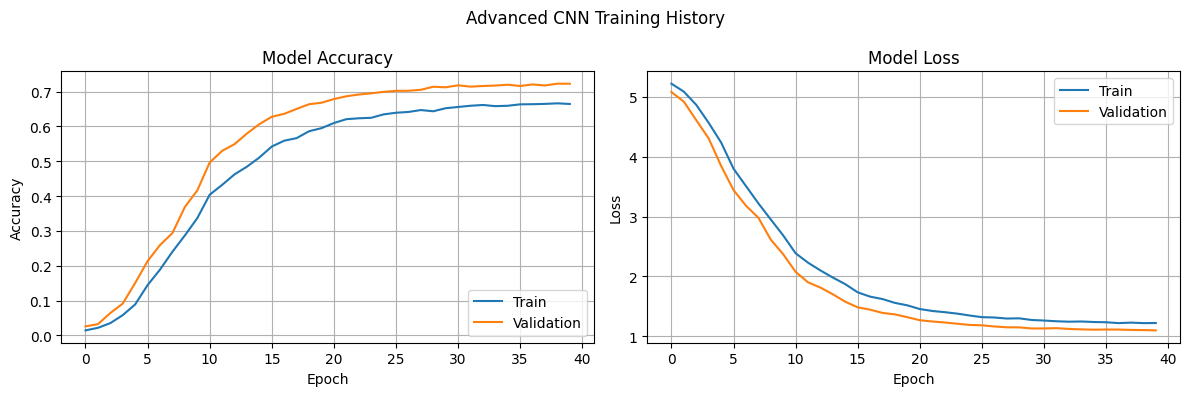

time: 349 ms (started: 2025-03-17 14:55:35 +00:00)


In [ ]:
# Cell 7: Visualize results and add to experiment tracker
print("Visualizing results and adding to experiment tracker")

# Plot training history
plot_training_history(history_advanced_cnn, title="Advanced CNN Training History")

# Add experiment to tracker
experiment_tracker.add_experiment("Advanced CNN", advanced_model, metrics_advanced_cnn, history_advanced_cnn)

### Experiment Comparison and Best Model Selection

In this block, we compare the performance of all experiments using metrics like accuracy and F1 score. We evaluate each experiment's results and visualize the comparison. <br>
The best model is identified based on these metrics, and it is saved to Google Drive along with relevant metadata for future use. This process ensures that we can track the best-performing model across all experiments.


COMPARING ALL CAR CLASSIFICATION EXPERIMENTS
Google Drive is already mounted
✅ Directory created successfully: /content/drive/MyDrive/car_classification_models
✅ Successfully verified write access to the directory

Available experiments:
1. Basic CNN (Validation Accuracy: 0.0888)
2. Modified DirectCNN (Validation Accuracy: 0.0816)
3. Advanced CNN (Validation Accuracy: 0.7226)

Metrics Comparison:
                        loss  accuracy        f1  precision    recall
Basic CNN           4.695539  0.088795  0.085234   0.097992  0.088795
Modified DirectCNN  4.543563  0.081582  0.062287   0.071692  0.081582
Advanced CNN        1.102624  0.722565  0.721761   0.729854  0.722565

Plotting accuracy comparison:


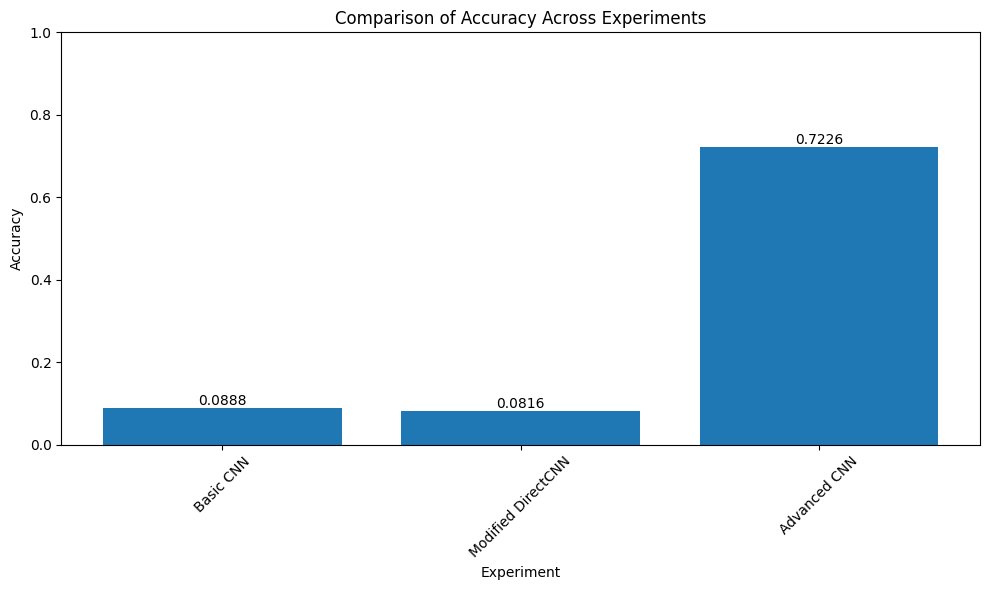


Plotting F1 score comparison:


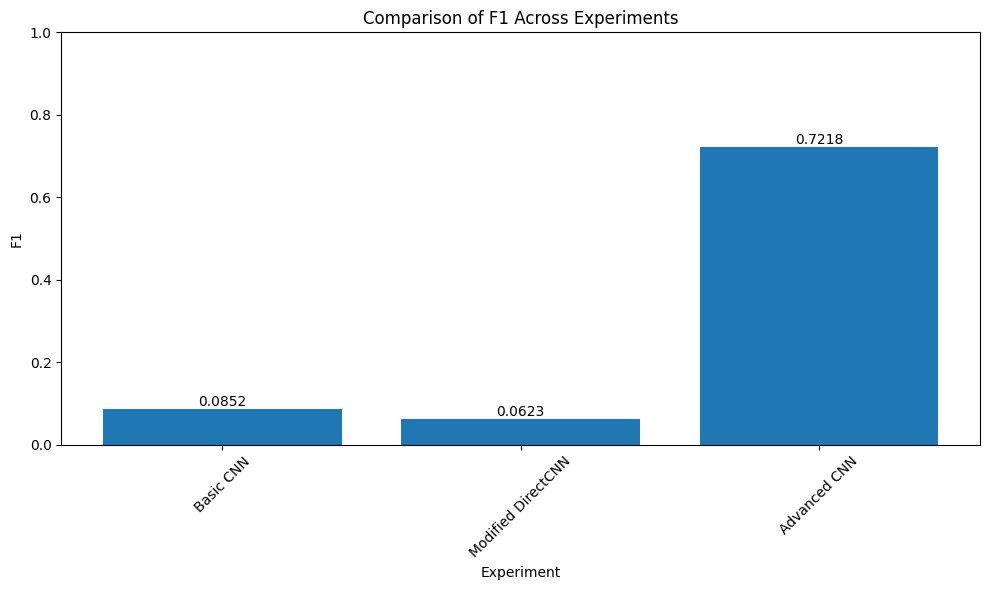


Plotting validation accuracy history:


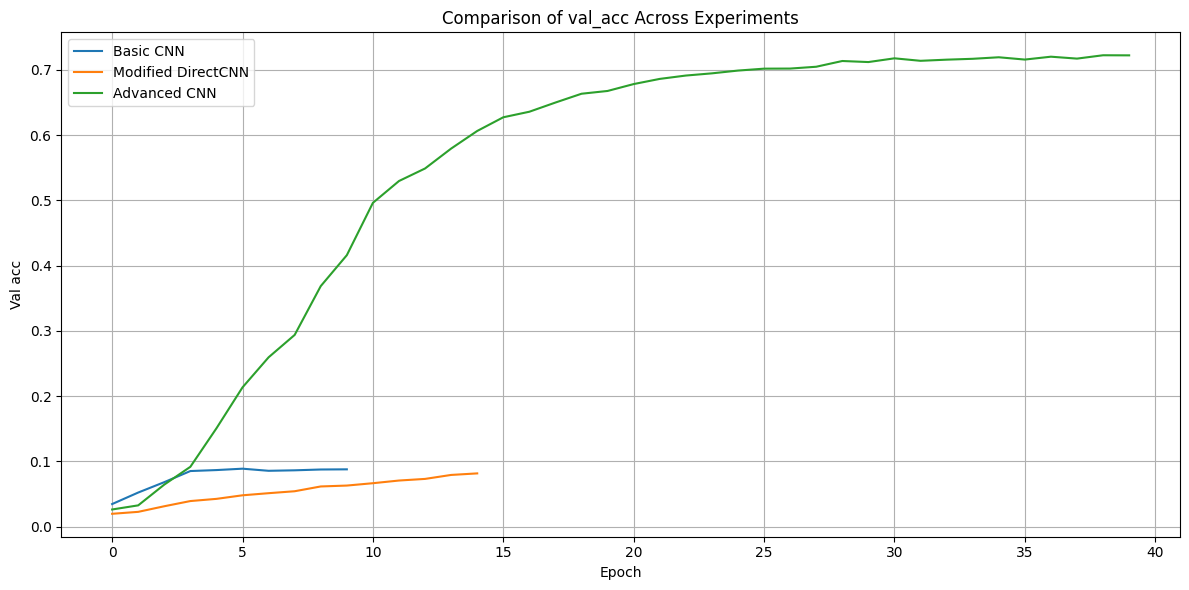


Plotting validation loss history:


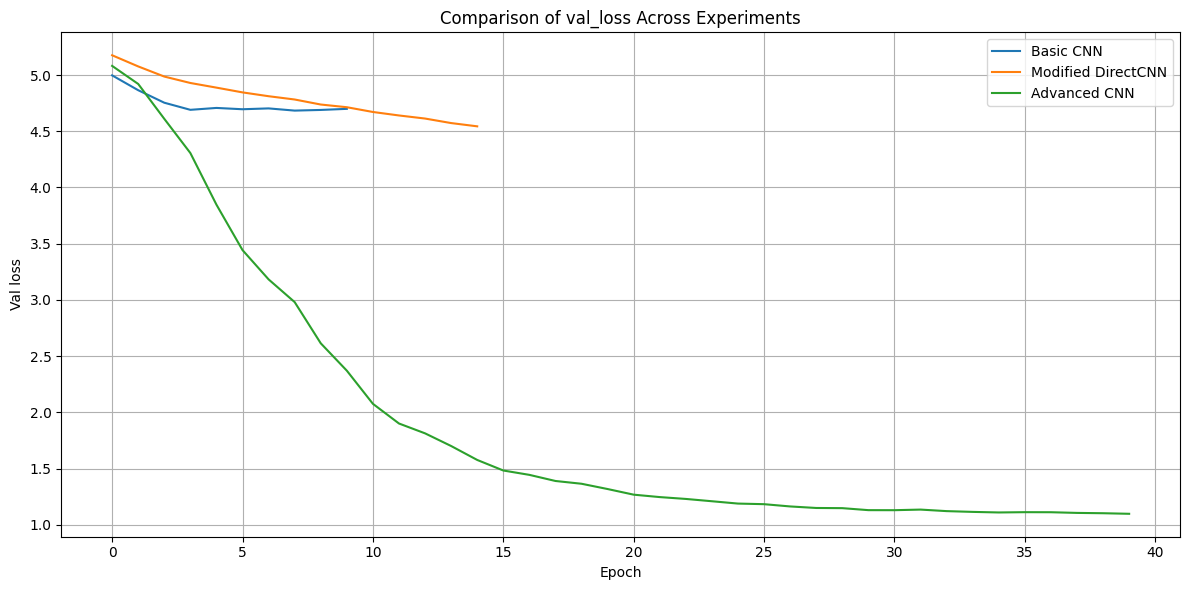

Best experiment based on accuracy: Advanced CNN with value 0.7226

Best experiment by accuracy: Advanced CNN with 0.7226
Best experiment based on f1: Advanced CNN with value 0.7218
Best experiment by F1 score: Advanced CNN with 0.7218
Best experiment based on accuracy: Advanced CNN with value 0.7226
✅ Best model (Advanced CNN) saved successfully to: /content/drive/MyDrive/car_classification_models/best_cnn_model.pth
✅ Model metadata saved to: /content/drive/MyDrive/car_classification_models/best_cnn_model_metadata.json
time: 677 ms (started: 2025-03-17 15:00:01 +00:00)


In [ ]:
from collections import Counter, defaultdict
# Compare all experiments and find the best model
print("\n" + "="*70)
print("COMPARING ALL CAR CLASSIFICATION EXPERIMENTS")
print("="*70)

# Mount Google Drive if not already mounted
try:
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')
        print("Google Drive mounted successfully")
    else:
        print("Google Drive is already mounted")
except ImportError:
    print("Not running in Colab, skipping Google Drive mount")

# Create a directory for models in Google Drive with verification
save_dir = "/content/drive/MyDrive/car_classification_models"
try:
    os.makedirs(save_dir, exist_ok=True)
    # Verify directory was created
    if os.path.exists(save_dir):
        print(f"✅ Directory created successfully: {save_dir}")
    else:
        print(f"⚠️ Failed to create directory: {save_dir}")
        # Fallback to a local directory
        save_dir = "./car_classification_models"
        os.makedirs(save_dir, exist_ok=True)
        print(f"Using local directory instead: {save_dir}")
except Exception as e:
    print(f"⚠️ Error creating directory: {e}")
    # Fallback to a local directory
    save_dir = "./car_classification_models"
    os.makedirs(save_dir, exist_ok=True)
    print(f"Using local directory instead: {save_dir}")

# Add a simple verification test to ensure we can write to Drive
try:
    test_file = f"{save_dir}/test_write.txt"
    with open(test_file, 'w') as f:
        f.write("Test file to verify write access")
    if os.path.exists(test_file):
        print("✅ Successfully verified write access to the directory")
    else:
        print("⚠️ Failed to verify write access")
except Exception as e:
    print(f"⚠️ Error writing test file: {e}")

# Print the list of available experiments
print("\nAvailable experiments:")
for i, exp_name in enumerate(experiment_tracker.experiments.keys()):
    # Get the validation accuracy for this experiment
    val_acc = experiment_tracker.experiments[exp_name]['metrics'].get('accuracy', 0)
    print(f"{i+1}. {exp_name} (Validation Accuracy: {val_acc:.4f})")

# Compare metrics across all experiments
metrics_comparison = experiment_tracker.compare_metrics()
print("\nMetrics Comparison:")
print(metrics_comparison)

# Plot metrics comparisons
print("\nPlotting accuracy comparison:")
experiment_tracker.plot_metric_comparison(metric="accuracy")

print("\nPlotting F1 score comparison:")
experiment_tracker.plot_metric_comparison(metric="f1")

# Plot training history comparisons
print("\nPlotting validation accuracy history:")
experiment_tracker.plot_history_comparison(metric="val_acc")

print("\nPlotting validation loss history:")
experiment_tracker.plot_history_comparison(metric="val_loss")

# Find best experiment based on accuracy
best_name, best_acc = experiment_tracker.find_best_experiment(metric="accuracy")
print(f"\nBest experiment by accuracy: {best_name} with {best_acc:.4f}")

# Find best experiment based on F1 score
best_name_f1, best_f1 = experiment_tracker.find_best_experiment(metric="f1")
print(f"Best experiment by F1 score: {best_name_f1} with {best_f1:.4f}")

# Save the best model to Google Drive with the new name
drive_save_path = f"{save_dir}/best_cnn_model.pth"
try:
    best_model_name = experiment_tracker.find_best_experiment(metric="accuracy")[0]
    if best_model_name:
        best_model = experiment_tracker.experiments[best_model_name]["model"]
        torch.save(best_model.state_dict(), drive_save_path)
        print(f"✅ Best model ({best_model_name}) saved successfully to: {drive_save_path}")
    else:
        print("⚠️ No best model found to save")
except Exception as e:
    print(f"⚠️ Error saving best model: {e}")

# Save metadata to help with loading the model later
try:
    if best_model_name:
        best_experiment = experiment_tracker.experiments[best_model_name]
        metadata = {
            "model_name": best_model_name,
            "num_classes": len(train_dataset.classes) if 'train_dataset' in globals() else 196,
            "metrics": best_experiment["metrics"]
        }

        metadata_path = f"{save_dir}/best_cnn_model_metadata.json"
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

        print(f"✅ Model metadata saved to: {metadata_path}")
except Exception as e:
    print(f"⚠️ Error saving model metadata: {e}")


## The Best Model

This block loads the best trained model and uses it to make predictions on new car images. The purpose is to classify the uploaded images based on the model's previous training. For each image, the model predicts the class, and the confidence level of the prediction is displayed. The block also handles multiple image uploads and displays the results for each one. This allows for easy evaluation of the model on new, unseen data.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully
Found 12 model file(s) in Drive:
1. /content/drive/MyDrive/car_classification_models/best_car_classification_model.pth
2. /content/drive/MyDrive/car_classification_models/Basic CNN_model.pth
3. /content/drive/MyDrive/car_classification_models/Modified DirectCNN_model.pth
4. /content/drive/MyDrive/car_classification_models/Advanced CNN_model.pth
5. /content/drive/MyDrive/car_classification_models/best_cnn_model.pth
6. /content/drive/MyDrive/car_classification_models/resnet50_finetune.pth
7. /content/drive/MyDrive/car_classification_models/DenseNet121_Progressive.pth
8. /content/drive/MyDrive/car_classification_models/best_transfer_learning_model.pth
9. /content/drive/MyDrive/car_classification_models/densenet121_progressive.pth
10. /content/drive/MyDrive/car_classification_models/ResNet50_FineTuning.pth
11. /content/drive/MyDr

Saving class_138.jpg to class_138.jpg
Saving class_66.jpg to class_66 (1).jpg
Saving class_145.jfif to class_145 (1).jfif
Saving class_133.jfif to class_133 (1).jfif

🔄 Processing 4 image(s)...
❌ INCORRECT: Filename class 138 (model index should be 137) differs from prediction (model index 133)


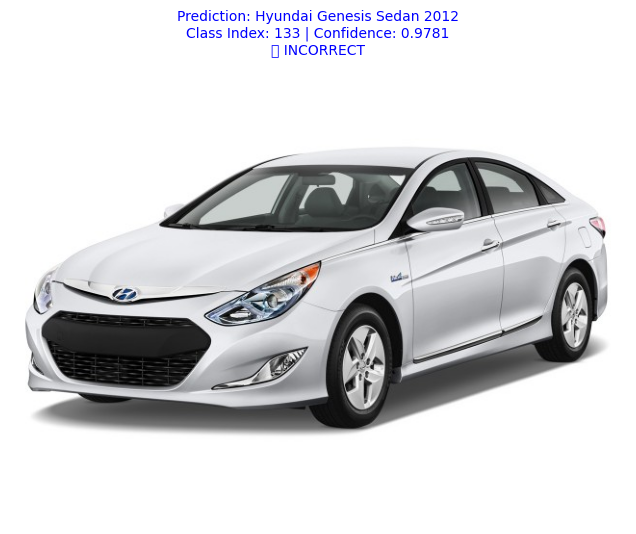

📄 File: class_138.jpg
🚗 Predicted car model: Hyundai Genesis Sedan 2012
🔢 Class index: 133
✓ Confidence: 0.9781
--------------------------------------------------
✅ CORRECT: Filename class 66 matches model index 65


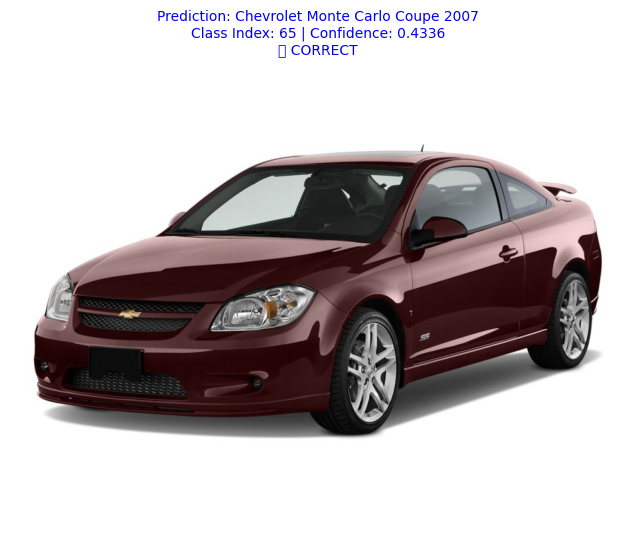

📄 File: class_66 (1).jpg
🚗 Predicted car model: Chevrolet Monte Carlo Coupe 2007
🔢 Class index: 65
✓ Confidence: 0.4336
--------------------------------------------------
✅ CORRECT: Filename class 145 matches model index 144


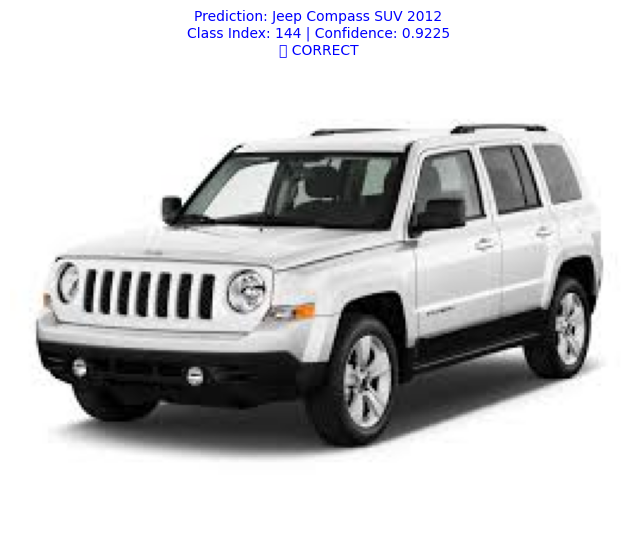

📄 File: class_145 (1).jfif
🚗 Predicted car model: Jeep Compass SUV 2012
🔢 Class index: 144
✓ Confidence: 0.9225
--------------------------------------------------
✅ CORRECT: Filename class 133 matches model index 132


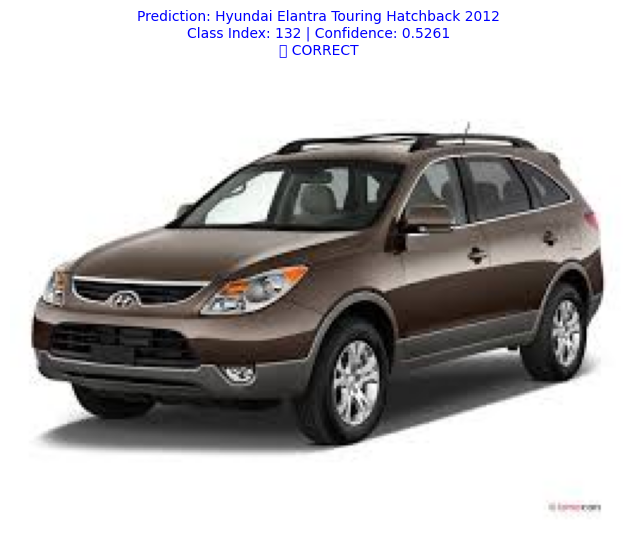

📄 File: class_133 (1).jfif
🚗 Predicted car model: Hyundai Elantra Touring Hatchback 2012
🔢 Class index: 132
✓ Confidence: 0.5261
--------------------------------------------------

✅ All images processed.

📤 Upload more car images or cancel to stop:


No more files uploaded. Finished.

Total images uploaded: 4
Correct predictions: 3 ✅
Incorrect predictions: 1 ❌
Accuracy: 75.00%
time: 22.3 s (started: 2025-03-17 15:24:55 +00:00)


In [ ]:
# Mount Google Drive if not already mounted
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully")
except:
    print("Google Drive already mounted or not in Colab")

# Find model files in Drive
model_files = glob.glob("/content/drive/MyDrive/car_classification_models/*.pth")
if model_files:
    print(f"Found {len(model_files)} model file(s) in Drive:")
    for i, path in enumerate(model_files):
        print(f"{i+1}. {path}")

    # Use the best CNN model
    best_model_path = "/content/drive/MyDrive/car_classification_models/best_cnn_model.pth"
    if os.path.exists(best_model_path):
        model_path = best_model_path
        print(f"\nUsing best CNN model: {model_path}")
    else:
        # Fallback to Advanced CNN model
        advanced_model_path = "/content/drive/MyDrive/car_classification_models/Advanced CNN_model.pth"
        if os.path.exists(advanced_model_path):
            model_path = advanced_model_path
            print(f"\nUsing Advanced CNN model: {model_path}")
        else:
            # Fallback to any model file
            model_path = model_files[0]
            print(f"\nUsing model: {model_path}")

    # Check if metadata file exists
    metadata_path = "/content/drive/MyDrive/car_classification_models/best_cnn_model_metadata.json"
    if not os.path.exists(metadata_path):
        metadata_path = "/content/drive/MyDrive/car_classification_models/best_model_metadata.json"

    # Load model information from metadata if available
    num_classes = 196  # Default - Stanford Cars has 196 classes
    model_name = "Advanced CNN"
    if os.path.exists(metadata_path):
        try:
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
                num_classes = metadata.get("num_classes", 196)
                model_name = metadata.get("model_name", "Advanced CNN")
                print(f"Loaded metadata: {model_name} with {num_classes} classes")
        except Exception as e:
            print(f"Error loading metadata: {e}")

    # Setup device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    class AdvancedCNN(nn.Module):
        def __init__(self, num_classes=196):
            super(AdvancedCNN, self).__init__()
            # First convolutional block with Spatial Dropout
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding='same')
            self.bn1 = nn.BatchNorm2d(32)
            self.pool1 = nn.MaxPool2d(2, 2)
            self.spatial_dropout1 = nn.Dropout2d(0.1)

            # Second convolutional block with more filters
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
            self.bn2 = nn.BatchNorm2d(64)
            self.pool2 = nn.MaxPool2d(2, 2)
            self.spatial_dropout2 = nn.Dropout2d(0.1)

            # Third convolutional block
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
            self.bn3 = nn.BatchNorm2d(128)
            self.pool3 = nn.MaxPool2d(2, 2)
            self.spatial_dropout3 = nn.Dropout2d(0.1)

            # Fourth convolutional block
            self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding='same')
            self.bn4 = nn.BatchNorm2d(256)
            self.pool4 = nn.MaxPool2d(2, 2)  # Output: 256 x 10 x 10

            # Global Average Pooling instead of flattening + FC layers
            self.gap = nn.AdaptiveAvgPool2d((1, 1))

            # Classification layers
            self.fc1 = nn.Linear(256, 512)
            self.bn5 = nn.BatchNorm1d(512)
            self.dropout1 = nn.Dropout(0.5)
            self.fc2 = nn.Linear(512, num_classes)

        def forward(self, x):
            # Block 1
            x = F.relu(self.bn1(self.conv1(x)))
            x = self.pool1(x)
            x = self.spatial_dropout1(x)

            # Block 2
            x = F.relu(self.bn2(self.conv2(x)))
            x = self.pool2(x)
            x = self.spatial_dropout2(x)

            # Block 3
            x = F.relu(self.bn3(self.conv3(x)))
            x = self.pool3(x)
            x = self.spatial_dropout3(x)

            # Block 4
            x = F.relu(self.bn4(self.conv4(x)))
            x = self.pool4(x)

            # Global Average Pooling
            x = self.gap(x)
            x = torch.flatten(x, 1)

            # Classification
            x = F.relu(self.bn5(self.fc1(x)))
            x = self.dropout1(x)
            x = self.fc2(x)

            return x

    # Create model instance with the right number of classes
    model = AdvancedCNN(num_classes=num_classes)

    # Load the saved model state directly from Drive
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    print(f"Model loaded successfully from {model_path}")

    # Try to load class names
    class_names = []
    try:
        # Try to load from Stanford Cars dataset
        stanford_cars_names = [
            "AM General Hummer SUV 2000", "Acura Integra Type R 2001", "Acura RL Sedan 2012",
            "Acura TL Sedan 2012", "Acura TL Type-S 2008", "Acura TSX Sedan 2012",
            "Acura ZDX Hatchback 2012", "Aston Martin V8 Vantage Convertible 2012",
            "Aston Martin V8 Vantage Coupe 2012", "Aston Martin Virage Convertible 2012",
            "Aston Martin Virage Coupe 2012", "Audi A5 Coupe 2012", "Audi R8 Coupe 2012",
            "Audi RS 4 Convertible 2008", "Audi S4 Sedan 2007", "Audi S4 Sedan 2012",
            "Audi S5 Convertible 2012", "Audi S5 Coupe 2012", "Audi S6 Sedan 2011",
            "Audi TT Hatchback 2011", "Audi TTS Coupe 2012", "Audi V8 Sedan 1994",
            "BMW 1 Series Convertible 2012", "BMW 1 Series Coupe 2012", "BMW 3 Series Sedan 2012",
            "BMW 3 Series Wagon 2012", "BMW 6 Series Convertible 2007", "BMW ActiveHybrid 5 Sedan 2012",
            "BMW M3 Coupe 2012", "BMW M5 Sedan 2010", "BMW M6 Convertible 2010", "BMW X3 SUV 2012",
            "BMW X5 SUV 2007", "BMW X6 SUV 2012", "BMW Z4 Convertible 2012"
        ]

        # Use Stanford car names if we have enough classes
        if len(stanford_cars_names) >= num_classes:
            class_names = stanford_cars_names[:num_classes]
        else:
            # Create simple class names as a fallback
            class_names = [f"Class_{i+1}" for i in range(num_classes)]

            # Try to load from dataset directory if available
            try:
                # Get all class folder names from the dataset path
                train_path = "/content/dataset/cars_train/cars_train"
                if os.path.exists(train_path):
                    class_folders = [os.path.basename(d) for d in glob.glob(os.path.join(train_path, "*")) if os.path.isdir(d)]
                    if len(class_folders) == num_classes:
                        class_names = sorted(class_folders)
                        print(f"Loaded {len(class_names)} class names from dataset folders")
            except Exception as e:
                print(f"Error loading class names from dataset: {e}")
    except Exception as e:
        print(f"Error loading class names: {e}")
        # Create simple class names as a fallback
        class_names = [f"Class_{i+1}" for i in range(num_classes)]

    print(f"Loaded {len(class_names)} class names")

    # Define transforms for the input images - note we're using grayscale since our model was trained on grayscale images
    test_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize((160, 160), interpolation=transforms.InterpolationMode.LANCZOS),  # Same size as in training
        transforms.ToTensor()
    ])

    # Initialize tracking variables for correct/incorrect predictions
    total_images = 0
    correct_predictions = 0
    incorrect_predictions = 0

    # Make sure we have the re module imported
    import re

    # Function to predict
    def predict_car_model(img_file):
        global total_images, correct_predictions, incorrect_predictions

        img = Image.open(img_file).convert('RGB')

        # Increment total images counter
        total_images += 1

        # Save original for display
        display_img = img.copy()

        # Transform for model input
        input_tensor = test_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            _, predicted_idx = torch.max(output, 1)
            predicted_class = predicted_idx.item()

            # Get confidence
            probs = torch.nn.functional.softmax(output, dim=1)
            confidence = probs[0][predicted_class].item()

        # Get class name
        class_name = class_names[predicted_class] if predicted_class < len(class_names) else f"Unknown Class {predicted_class}"

        # Try to extract class number from filename for verification
        try:
            filename = img_file.name.lower()
            # Updated regex pattern to match filenames like "class_1.jpg" or "class_42 (1).jfif"
            match = re.search(r'class_?(\d+)', filename)
            if match:
                file_class = int(match.group(1))
                expected_model_idx = file_class - 1  # Adjust for class numbering (0-based indexing)

                if expected_model_idx == predicted_class:
                    correct_predictions += 1
                    accuracy_result = "✅ CORRECT"
                    print(f"✅ CORRECT: Filename class {file_class} matches model index {predicted_class}")
                else:
                    incorrect_predictions += 1
                    accuracy_result = "❌ INCORRECT"
                    print(f"❌ INCORRECT: Filename class {file_class} (model index should be {expected_model_idx}) differs from prediction (model index {predicted_class})")
            else:
                accuracy_result = ""
                print(f"⚠️ WARNING: Could not extract class number from filename: {filename}")
        except Exception as e:
            accuracy_result = ""
            print(f"⚠️ ERROR extracting class from filename: {str(e)}")

        # Display the image with prediction
        plt.figure(figsize=(8, 6))
        plt.imshow(display_img)
        plt.axis('off')

        # Set title with prediction
        title = f"Prediction: {class_name}\nClass Index: {predicted_class} | Confidence: {confidence:.4f}"
        if accuracy_result:
            title += f"\n{accuracy_result}"

        plt.title(title, fontsize=10, color='blue')
        plt.show()

        # Print the prediction
        print(f"📄 File: {img_file.name}")
        print(f"🚗 Predicted car model: {class_name}")
        print(f"🔢 Class index: {predicted_class}")
        print(f"✓ Confidence: {confidence:.4f}")
        print("-" * 50)

    # Function to handle multiple image uploads
    def upload_and_predict_multiple():
        global total_images, correct_predictions, incorrect_predictions

        print("\n" + "="*50)
        print("CAR IMAGE CLASSIFICATION USING CNN MODEL")
        print("="*50)
        print("\n📤 Upload car images for classification (you can select multiple files):")

        # Reset counters
        total_images = 0
        correct_predictions = 0
        incorrect_predictions = 0

        # Keep uploading files until the user is done
        continue_uploading = True

        while continue_uploading:
            uploaded = files.upload()

            if not uploaded:
                print("No files uploaded.")
                break

            print(f"\n🔄 Processing {len(uploaded)} image(s)...")

            for filename, content in uploaded.items():
                img_file = io.BytesIO(content)
                img_file.name = filename
                predict_car_model(img_file)

            # Ask if user wants to upload more images
            print("\n✅ All images processed.")

            # Upload more images if desired
            print("\n📤 Upload more car images or cancel to stop:")
            uploaded = files.upload()

            if not uploaded:
                continue_uploading = False
                print("No more files uploaded. Finished.")

        # Print final statistics
        print(f"\nTotal images uploaded: {total_images}")
        print(f"Correct predictions: {correct_predictions} ✅")
        print(f"Incorrect predictions: {incorrect_predictions} ❌")

        # Calculate accuracy if any images were processed
        if total_images > 0:
            accuracy = correct_predictions / total_images * 100
            print(f"Accuracy: {accuracy:.2f}%")

    # Start the upload process
    upload_and_predict_multiple()

else:
    print("No model files found in Drive!")